In [31]:
# 1 - EXPLORAÇÃO DA BASE DE DADOS
import glob
import cv2
import matplotlib.pyplot as plt

# Método que exibe imagens das classes que serão apresentadas na próxima célula
def show_multiple_imgs_plt(images_array, titles_array, fig_size=(15, 15), show_axis=False):
    # Determinar o número de linhas e colunas
    num_rows = len(images_array)
    num_cols = len(images_array[0]) if num_rows > 0 else 0
    
    # Criar a figura e os eixos
    _, axis = plt.subplots(num_rows, num_cols, figsize=fig_size)
    
    # Garantir que 'axis' seja sempre uma lista de listas
    if num_rows == 1:
        axis = [axis]
    if num_cols == 1:
        axis = [[ax] for ax in axis]

    # Exibir as imagens
    for i in range(num_rows):
        for j in range(num_cols):
            ax = axis[i][j]
            ax.imshow(cv2.cvtColor(images_array[i][j], cv2.COLOR_BGR2RGB))
            ax.set_anchor('NW')
            ax.set_title(titles_array[i][j], fontdict={'fontsize': 15, 'fontweight': 'medium'}, pad=10)
            if not show_axis:
                ax.axis('off')

    plt.tight_layout()
    plt.show()

Número de imagens saudáveis: 100
Número de imagens doentes: 100


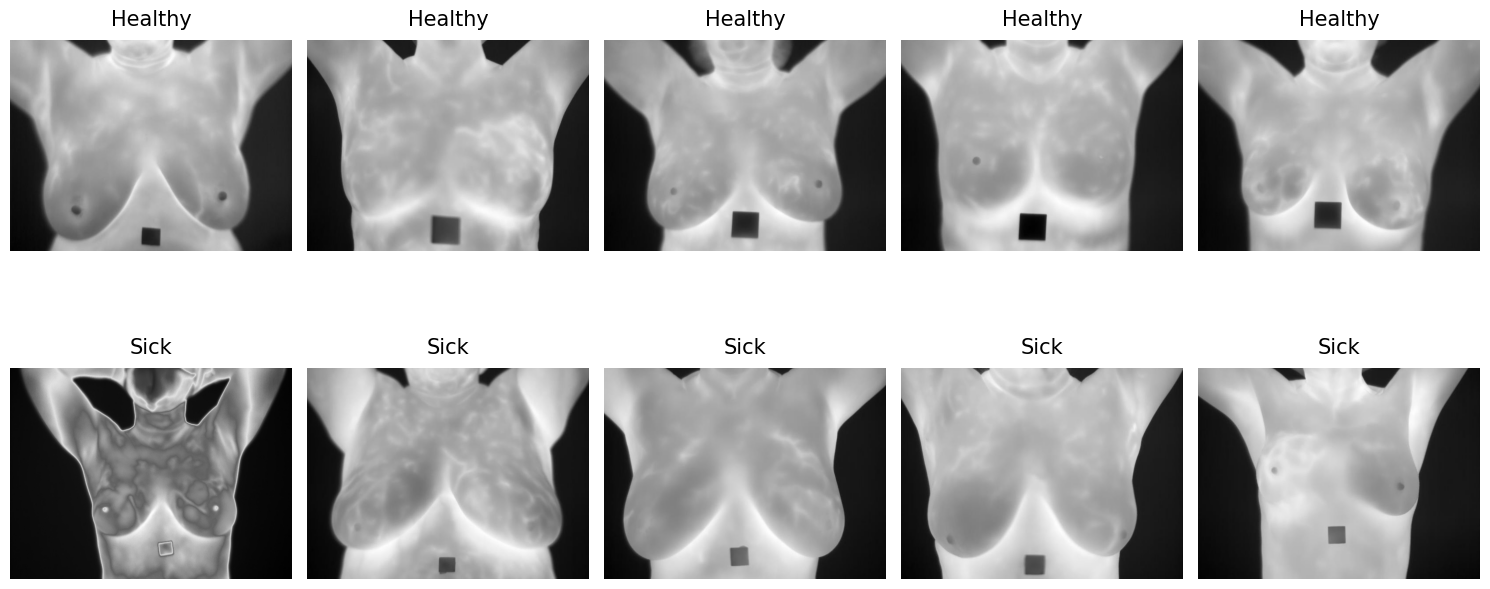

In [32]:
# 1 - EXPLORAÇÃO DA BASE DE DADOS

# A base de dados utilizada é a DMR-IR, que contém imagens termográficas das mamas coletadas pelo
# Laboratório Visual para Pesquisa em Mastologia da Universidade Federal Fluminense (UFF) 
# em Niterói, Brasil. As imagens foram capturadas usando uma câmera térmica FLIR SC620 e possuem 
# resolução de 480 x 640 pixels. A base de dados inclui três classes de imagens: healthy (saudáveis),
# sick (doentes), e unknown (desconhecidas) de pacientes numerados de 1 a 287. Para este projeto, 
# foram usadas apenas imagens das classes "healthy" e "sick".

# Relevância para o Treinamento do Modelo: A classificação de interesse neste projeto é entre
# "saudável" (healthy) e "doente" (sick). A classe "unknown" contém imagens de casos que não 
# foram diagnosticados ou não possuem uma classificação clara, o que poderia introduzir ruído 
# e incerteza nos dados de treinamento, dificultando a aprendizagem do modelo e a interpretação 
# dos resultados.

# Optou-se por baixar as imagens em escala de cinza devido à natureza da análise termográfica, 
# onde a variação de temperatura é o foco principal. As imagens em escala de cinza facilitam a 
# interpretação dos dados térmicos, removendo a complexidade que pode ser introduzida por 
# imagens coloridas.

# Definindo o caminho da base de dados
# Ao baixar as imagens do site http://visual.ic.uff.br/dmi/, as separei em duas pastas diferentes
# uma para as classificadas como healthy.
ROOT_PATH = "D:/Unifesp/IA/termografia/termography/dataset"
healthy_data_path  = ROOT_PATH + "/healthy/"
sick_data_path     = ROOT_PATH + "/sick/"

# Carregando lista dos caminhos da imagens de cada classe
healthy_list = glob.glob(healthy_data_path + '*.jpg')
sick_list    = glob.glob(sick_data_path + '*.jpg')

# Analisando a base de dados
print(f"Número de imagens saudáveis: {len(healthy_list)}")
print(f"Número de imagens doentes: {len(sick_list)}")


# Exibindo algumas imagens das classes "healthy" e "sick"
n_imgs = 5

imgs_healthy   = [cv2.imread(x) for x in healthy_list[:n_imgs]]
labels_healthy = ['Healthy' for x in healthy_list[:n_imgs]]

imgs_sick   = [cv2.imread(x) for x in sick_list[:n_imgs]]
labels_sick = ['Sick' for x in sick_list[:n_imgs]]

imgs   = imgs_healthy + imgs_sick
labels = labels_healthy + labels_sick

show_multiple_imgs_plt([imgs[:5], imgs[5:]], [labels[:5], labels[5:]], fig_size = (15,8), show_axis=False)

In [33]:
# 2 - LIMPEZA DOS DADOS
# Conforme mencionadoa anteriormente, as imagens tiveram que ser baixadas uma a uma, logo
# parte do trabalho foi selecionar no site da base de dados as imagens que fossem frontais
# e com classificação healthy ou sick, já que ununknown não é interessante tanto para o treinamento
# quanto validação.

# Função para limpar e redimensionar imagens que não estejam no tamanho informado pela base dados ou corrompidas
def preprocess_image(img, size=(640, 480)):
    # Verificar se a imagem foi carregada corretamente
    if img is None:
        return None
    # Redimensionar a imagem
    img_resized = cv2.resize(img, size)
    return img_resized

# Lendo as imagens em escala de cinza, já que as cores não são pertinentes para o treinamento da rede, uma vez que
# a termografia pode ser analisada em apenas uma camada da imagem sendo onde está mais claro são regiões mais quentes
# e mais escuro regiões mais frias.
healthy_list = [preprocess_image(cv2.imread(x, cv2.IMREAD_GRAYSCALE)) for x in healthy_list]
sick_list = [preprocess_image(cv2.imread(x, cv2.IMREAD_GRAYSCALE)) for x in sick_list]

# Removendo imagens que não foram carregadas corretamente
healthy_list = [img for img in healthy_list if img is not None]
sick_list = [img for img in sick_list if img is not None]

print(f"Imagens saudáveis após limpeza: {len(healthy_list)}")
print(f"Imagens doentes após limpeza: {len(sick_list)}")

Imagens saudáveis após limpeza: 100
Imagens doentes após limpeza: 100


In [34]:
# Imports:
from __future__ import print_function, division

import torch
import torch.backends.cudnn as cudnn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import time
import os
from PIL import Image

In [35]:
# 3 - FORMATAÇÃO DOS DADOS PARA UTILIZAÇÃO PELO ALGORITMO DE APRENDIZAGEM

# Limpar o cache da CUDA
torch.cuda.empty_cache()
cudnn.benchmark = True

class CustomImageDataset(Dataset):
    """
    A classe CustomImageDataset é uma implementação personalizada do PyTorch Dataset para carregar e
    transformar imagens a partir da lista de imagens fornecida. Cada imagem é carregada a partir do 
    disco e convertida para o formato RGB, e a transformação é aplicada se fornecida.
    """
    def __init__(self, images_list, root_path, transform=None):
        self.images_list = images_list
        self.transform = transform
        self.root_path = root_path

    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # constrói o caminho completo para a imagem a ser carregada
        img_name = os.path.join(self.root_path, self.images_list[idx]['subfolder'], self.images_list[idx]['img'])
        # converte a imagem para o formato RGB
        image = Image.open(img_name).convert('RGB')
        # obtém label da imagem a partir da lista de imagens
        label = self.images_list[idx]['label']

        # aplica a transformação, se fornecida
        if self.transform:
            image = self.transform(image)

        return image, label

def resnet18_data_preprocessing(images_list, root_path, batch_size=32, workers=2, device='cuda:0'):
    """
    organiza e prepara os dados de imagem para treinamento e teste, configurando transformações, 
    criando datasets e dataloaders, e configurando o dispositivo para processamento. 
    """

    # define o tamanho padrão para ResNet18, o size padrão é 224
    RESNET18_RESIZE = 224
    # valores para normalização, são os melhores valores para Resnet18
    RESNET_NORMALIZE_VALUES = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    # compõe as transformações de dados
    data_transforms = transforms.Compose([
        transforms.Resize((RESNET18_RESIZE, RESNET18_RESIZE)),
        transforms.ToTensor(),
        transforms.Normalize(*RESNET_NORMALIZE_VALUES)
    ])

    # cria os datasets
    train_dataset = CustomImageDataset(images_list[0], root_path, transform=data_transforms)
    test_dataset = CustomImageDataset(images_list[1], root_path, transform=data_transforms)

    # cria os dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=workers)

    # tamanhos do dataset e nomes das classes
    dataset_sizes = {'train': len(train_dataset), 'test': len(test_dataset)}
    class_names = list(set(img['label'] for img in images_list[0] + images_list[1]))

    # configura device
    device = torch.device(device if torch.cuda.is_available() else "cpu")

    return {'train': train_loader, 'test': test_loader}, dataset_sizes, class_names, device

In [36]:
# 4 - SEPRAR A BASE EM TREINO (80%) E TESTE (20%)
# Foi conversado com o professor em usar cross-validation 10-fold, ou seja,
# com 200 itens e usando KFold com n_splits=10, o KFold dividirá o array em 10 partes iguais,
# cada uma contendo 20 itens. Cada uma das 10 partes será usada como conjunto de validação uma vez,
# enquanto as outras 9 partes (180 itens) serão usadas como conjunto de treino.

import os
import random
from sklearn.model_selection import KFold
random.seed(1234)

def get_subfolders_dictionary(root_path):
    """
    Cria uma lista de dicionários contendo informações sobre as imagens em cada subpasta.
    Cada dicionário contém o caminho da imagem, o nome da subpasta (classe) e o rótulo numérico da classe.
    """
    images_list = []
    labels_dict = {}
    current_label = 0

    # itera sobre todas as subpastas no caminho raiz
    for subfolder in os.listdir(root_path):
        if os.path.isdir(os.path.join(root_path, subfolder)):
            # obtém a lista de imagens na subpasta
            images = [image for image in os.listdir(os.path.join(root_path, subfolder)) if image.endswith(('.jpg'))]
            for img in images:
                # gerando um número único para cada nome da pasta de imagens
                if subfolder in labels_dict:
                    label = labels_dict[subfolder]
                else:
                    label = current_label
                    labels_dict[subfolder] = label
                    current_label += 1

                # lista irá conter dicionário com o nome da subpasta, nome da imagem e o label dela (int)
                images_list.append({"subfolder": subfolder, "img": img, "label": label})
    return images_list



def split_dataset_kfold(images_list, n_splits=10):
    """
    Divide a lista de imagens em K folds para validação cruzada.

    Args:
    images_list (list): Lista contendo os caminhos das imagens.
    n_splits (int): Número de folds para dividir os dados.

    Returns:
    list: Lista de tuplas contendo os conjuntos de treino e validação para cada fold.
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=1234)
    splits = []

    for train_idx, val_idx in kf.split(images_list):
        train_set = [images_list[i] for i in train_idx]
        val_set = [images_list[i] for i in val_idx]
        splits.append((train_set, val_set))

    return splits

In [37]:
# 5 - EXECUTAR O TREINAMENTO E VALIDAÇÃO DO MODELO ESCOLHIDO
def train_model(model, dataloaders, dataset_sizes, device, criterion, optimizer, scheduler, num_epochs=25):
    '''
    Realiza o treinamento do modelo.

    Argumentos:
    model -- O modelo a ser treinado.
    dataloaders -- Dicionário contendo DataLoaders para conjuntos de treinamento e teste.
    dataset_sizes -- Dicionário com o tamanho dos conjuntos de treinamento e teste.
    device -- O dispositivo onde o treinamento será realizado (CPU ou GPU).
    criterion -- A função de perda usada para calcular a perda durante o treinamento.
    optimizer -- O otimizador usado para atualizar os parâmetros do modelo.
    scheduler -- O agendador de taxa de aprendizado para ajustar a taxa de aprendizado durante o treinamento.
    num_epochs -- O número de épocas para o treinamento.

    Retorna:
    model -- O modelo treinado.
    '''


    print('#################################################################################')
    print(f'Start training model:')
    print('#################################################################################')

    # loop de treinamento por número de épocas
    for epoch in range(num_epochs):
        print('#################################################################################')
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('#################################################################################')

        # define o modelo em modo de treinamento
        model.train()  

        running_loss = 0.0
        running_corrects = 0

        # itera sobre os dados no DataLoader de treinamento
        for inputs, labels in dataloaders['train']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zera os gradientes dos parâmetros
            optimizer.zero_grad()

            # passagem para frente e retropropagação
            outputs = model(inputs) # passagem para frente
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels) # calcula a perda

            # calcula os gradientes da perda em relação aos parâmetros do modelo
            loss.backward()
            # atualiza os parâmetros do modelo com base nos gradientes calculados
            optimizer.step()

            # atualiza as estatísticas de perda
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # atualiza a taxa de aprendizado com o scheduler
        scheduler.step()

        # calcula a perda e a acurácia da época
        epoch_loss = running_loss / dataset_sizes['train']
        epoch_acc = running_corrects.double() / dataset_sizes['train']

        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')


    return model

In [38]:
from sklearn.metrics import accuracy_score

def infer_model(model, data_loader, device):
    '''
    Avalia o modelo em um DataLoader de teste e calcula a precisão.

    Argumentos:
    model -- O modelo treinado a ser avaliado.
    data_loader -- Dicionário contendo o DataLoader de teste.
    device -- O dispositivo onde a inferência será realizada (CPU ou GPU).

    Retorna:
    accuracy -- A precisão do modelo no conjunto de teste.
    all_preds -- Lista de previsões do modelo.
    all_labels -- Lista de rótulos reais.
    '''

    # coloca o modelo em modo de avaliação
    model.eval()
    all_preds = []
    all_labels = []

    # desabilita o cálculo do gradiente para economia de memória
    with torch.no_grad():  
        for inputs, labels in data_loader['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # realiza a passagem para frente (forward pass) : calcula as previsões do modelo para as entradas fornecidas
            outputs = model(inputs)
            # obtém os índices das classes com a maior probabilidade
            _, preds = torch.max(outputs, 1)

            # converte as previsões para o formato NumPy e adiciona à lista de previsões
            all_preds.extend(preds.cpu().numpy())
            # converte os rótulos verdadeiros para o formato NumPy e adiciona à lista de rótulos verdadeiros
            all_labels.extend(labels.cpu().numpy())

    # calcula a precisão
    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy, all_preds, all_labels

In [39]:
# Preparação dos dados
root_path = ROOT_PATH
images_list = get_subfolders_dictionary(root_path)

# Dividindo os dados em 10 folds
kfold_splits = split_dataset_kfold(images_list, n_splits=2)

# Inicializando listas para guardar métricas de desempenho
all_accuracies = []

In [40]:
from torchvision import models
from torch.optim import lr_scheduler

import torch.nn as nn
import torch.optim as optim

# valores ajustados a partir de testes
learning_rate  = 0.001 # hiperparâmetro que define o tamanho do passo que o otimizador dá em cada iteração para minimizar a função de perda.
momentum       = 0.8   # hiperparâmetro que ajuda a acelerar o treinamento acumulando o gradiente passado para suavizar a atualização atual.
lr_decay_gamma = 0.5   # fator pelo qual a taxa de aprendizado é multiplicada quando o scheduler atualiza a taxa de aprendizado.
lr_decay_step  = 5     # número de épocas após o qual a taxa de aprendizado é reduzida.
num_epochs     = 20    # quantidade de vezes que o modelo passará por todo o conjunto de dados durante o treinamento.


# Loop de treinamento e validação para cada fold
for fold, (train_set, val_set) in enumerate(kfold_splits):
    print(f'Fold {fold + 1}/{len(kfold_splits)}')

    # Preparar os data loaders para este fold
    data_loaders, dataset_sizes, class_names, device = resnet18_data_preprocessing([train_set, val_set], root_path, batch_size=8, workers=0, device='cuda:0')

    # Configurar o modelo, critério, otimizador e scheduler
    model_ft = models.resnet18(pretrained=True)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, len(class_names))
    model_ft = model_ft.to(device)
    criterion = nn.CrossEntropyLoss()

    # Configuração do otimizador e scheduler
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=learning_rate, momentum=momentum)
    scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=lr_decay_step, gamma=lr_decay_gamma)

    # Treinar o modelo
    model_ft = train_model(model_ft, data_loaders, dataset_sizes, device, criterion, optimizer_ft, scheduler, num_epochs)

    # Avaliar o modelo
    val_accuracy, val_preds, val_labels = infer_model(model_ft, {'test': data_loaders['test']}, device)
    print(f'Fold {fold + 1} - Validação Precisão: {val_accuracy * 100:.2f}%')
    
    # Guardar a precisão deste fold
    all_accuracies.append(val_accuracy)


Fold 1/2
#################################################################################
Start training model:
#################################################################################
#################################################################################
Epoch 0/19
#################################################################################
Train Loss: 0.6305 Acc: 0.6300
#################################################################################
Epoch 1/19
#################################################################################
Train Loss: 0.4573 Acc: 0.7300
#################################################################################
Epoch 2/19
#################################################################################
Train Loss: 0.2111 Acc: 0.9600
#################################################################################
Epoch 3/19
#################################################################################
Train Loss: 

In [41]:
import numpy as np

# Calcular a média e desvio padrão das precisões de todos os folds
mean_accuracy = np.mean(all_accuracies)
std_accuracy = np.std(all_accuracies)

print(f'Média da Precisão: {mean_accuracy * 100:.2f}%')
print(f'Desvio Padrão da Precisão: {std_accuracy * 100:.2f}%')

Média da Precisão: 88.00%
Desvio Padrão da Precisão: 2.00%


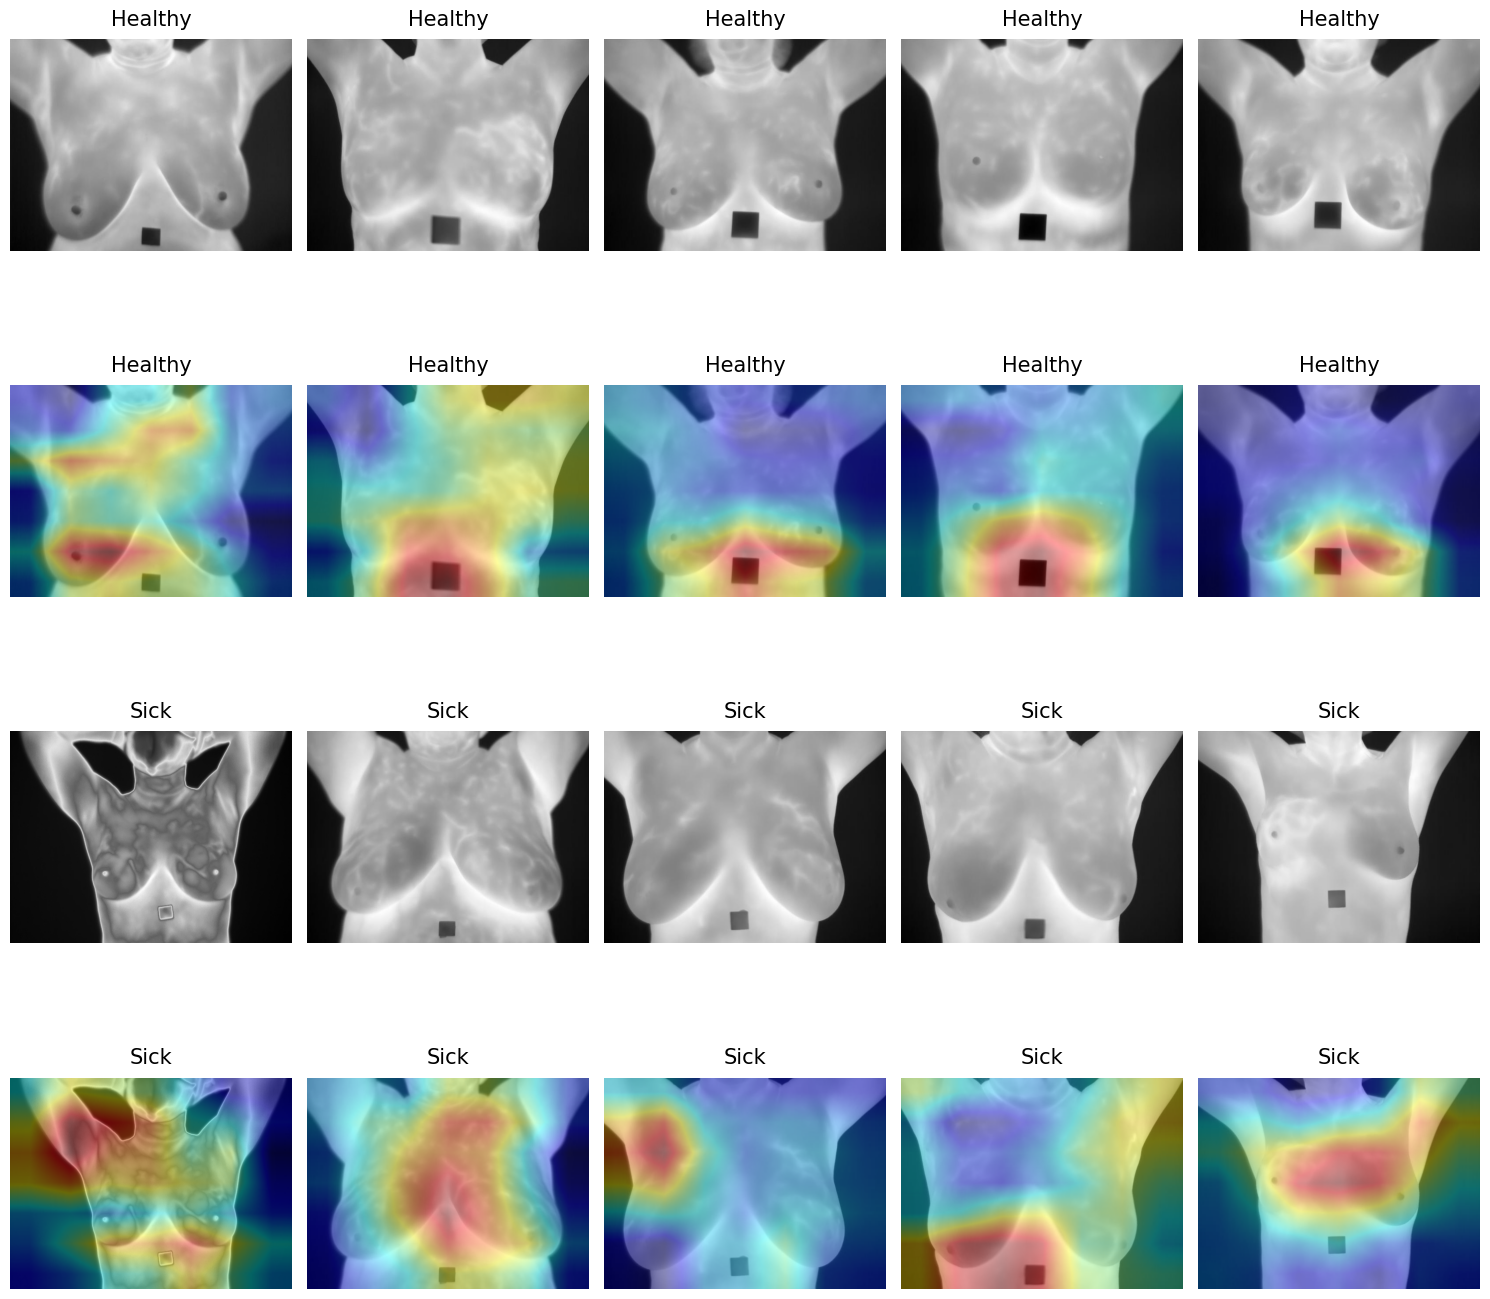

In [45]:
import numpy as np
import cv2
from torchvision import transforms
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from PIL import Image

# Hook para capturar as ativações do último layer convolucional
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())

def returnCAM(feature_conv, weight_softmax, class_idx):
    size_upsample = (224, 224)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

def preprocess_image(image, transform):
    # Aplica as transformações definidas na função resnet18_data_preprocessing
    image = transform(image)
    return image

def generate_cam(img, model, transform, feature_layer_name='layer4', class_names=['Healthy', 'Sick']):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Verificar se a imagem está em escala de cinza e converter para RGB se necessário
    if len(img.shape) == 2 or img.shape[2] == 1:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    # Converter a imagem para o formato uint8, se necessário
    if img.dtype != np.uint8:
        img = (255 * (img / np.max(img))).astype(np.uint8)

    # Converter a imagem do formato numpy array para PIL Image e preprocessá-la
    img_pil = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    img_tensor = preprocess_image(img_pil, transform).to(device)
    img_variable = Variable(img_tensor.unsqueeze(0)).to(device)

    # Definir o modelo para modo de avaliação e movê-lo para o dispositivo correto
    model.to(device).eval()
    
    # Adicionar hook à última camada convolucional
    features_blobs.clear()
    model._modules.get(feature_layer_name).register_forward_hook(hook_feature)
    
    # Realizar a previsão
    logit = model(img_variable)
    
    # Obter os pesos do softmax
    params = list(model.parameters())
    weight_softmax = np.squeeze(params[-2].data.cpu().numpy())
    
    # Obter as previsões
    h_x = F.softmax(logit, dim=1).data.cpu().squeeze()  # Mover o tensor para CPU antes de chamar .numpy()
    probs, idx = h_x.sort(0, True)
    idx = idx.cpu().numpy()  # Mover o tensor para CPU antes de chamar .numpy()
    
    # Gerar CAM para a classe predita
    CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0]])

    # Renderizar a CAM
    height, width, _ = img.shape
    heatmap = cv2.applyColorMap(cv2.resize(CAMs[0], (width, height)), cv2.COLORMAP_JET)
    result = heatmap * 0.3 + img * 0.5

    return result, class_names[idx[0]]

# Exemplo de uso após o treinamento do modelo
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def convert_to_rgb_and_normalize_to_uint8(img):
    # Verificar se a imagem está em escala de cinza e converter para RGB se necessário
    if len(img.shape) == 2 or img.shape[2] == 1:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    # Converter a imagem para o formato uint8, se necessário
    if img.dtype != np.uint8:
        img = (255 * (img / np.max(img))).astype(np.uint8)
    return img

for i in range(len(imgs_healthy)):
    imgs_healthy[i] = convert_to_rgb_and_normalize_to_uint8(imgs_healthy[i])

for i in range(len(imgs_sick)):
    imgs_sick[i] = convert_to_rgb_and_normalize_to_uint8(imgs_sick[i])


cams_healthy = [generate_cam(x, model_ft, transform)[0] for x in healthy_list[:n_imgs]]
cams_sick = [generate_cam(x, model_ft, transform)[0] for x in sick_list[:n_imgs]]

for i in range(len(cams_healthy)):
    cams_healthy[i] = convert_to_rgb_and_normalize_to_uint8(cams_healthy[i])

for i in range(len(cams_sick)):
    cams_sick[i] = convert_to_rgb_and_normalize_to_uint8(cams_sick[i])

imgs_combined = [imgs_healthy, cams_healthy, imgs_sick, cams_sick]
labels_combined = [labels_healthy, labels_healthy, labels_sick, labels_sick]

show_multiple_imgs_plt(imgs_combined, labels_combined, fig_size=(15, 15), show_axis=False)


In [43]:
# 6- RESPONDER À PERGUNTA: "VOCÊ ACREDITA QUE SERÁ POSSÍVEL ENTREGAR TUDO QUE PROMETEU NO DOCUMENTO DA PROPOSTA?"
# Sim